In [64]:
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import uuid
import math
import random
import time
from shutil import copyfile, rmtree
import os
import glob

#from scipy.ndimage.measurements import label
#from sklearn.model_selection import train_test_split

import tensorflow as tf

from shapely.geometry import LineString, Point, LinearRing, Polygon

In [65]:
import sys
sys.path.append("../tf-models")
sys.path.append("../tf-models/slim")
sys.path.append("../tf-models/object_detection")
sys.path.append("../tf-models/object_detection/utils")

from utils import label_map_util
from utils import visualization_utils as vis_util

## Computer vision: arrow

In [66]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def pipeline_vision_final(image_src):
    PATH_TO_CKPT = os.path.join('elements_inference_graph', 'frozen_inference_graph.pb')
    PATH_TO_LABELS = os.path.join('elements_inference_graph', 'object_detection.pbtxt')
    NUM_CLASSES = 1
    IMAGE_SIZE_DISPLAY = (12, 8)
    
    label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
    categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    
    # load saved model
    detection_graph = tf.Graph()
    with detection_graph.as_default():
      od_graph_def = tf.GraphDef()
      with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
    
    # predic
    TEST_IMAGE_PATHS = [image_src]
    result = []
    with detection_graph.as_default():
      with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        for image_path in TEST_IMAGE_PATHS:
          image = Image.open(image_path)
          # the array based representation of the image will be used later in order to prepare the
          # result image with boxes and labels on it.
          image_np = load_image_into_numpy_array(image)
          # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
          image_np_expanded = np.expand_dims(image_np, axis=0)
          # Actual detection.
          (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})
          # Visualization of the results of a detection.
          vis_util.visualize_boxes_and_labels_on_image_array(
              image_np,
              np.squeeze(boxes),
              np.squeeze(classes).astype(np.int32),
              np.squeeze(scores),
              category_index,
              use_normalized_coordinates=True,
              line_thickness=8)
          
          plt.figure(figsize=IMAGE_SIZE_DISPLAY)
          plt.imshow(image_np)
          plt.show()
          cv2.imwrite('prediction/arrows.jpg',image_np)
            
          result.append((boxes, scores, classes, num))
    
    return result

## Process lines 

In [67]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html
# https://stackoverflow.com/questions/32702075/what-would-be-the-fastest-way-to-find-the-maximum-of-all-possible-distances-betw
def lines_close(line1, line2):
    dist1 = math.hypot(line1[0][0] - line2[0][0], line1[0][0] - line2[0][1])
    dist2 = math.hypot(line1[0][2] - line2[0][0], line1[0][3] - line2[0][1])
    dist3 = math.hypot(line1[0][0] - line2[0][2], line1[0][0] - line2[0][3])
    dist4 = math.hypot(line1[0][2] - line2[0][2], line1[0][3] - line2[0][3])
    
    if (min(dist1,dist2,dist3,dist4) < 100):
        return True
    else:
        return False
    
def lineMagnitude (x1, y1, x2, y2):
    lineMagnitude = math.sqrt(math.pow((x2 - x1), 2)+ math.pow((y2 - y1), 2))
    return lineMagnitude
 
#Calc minimum distance from a point and a line segment (i.e. consecutive vertices in a polyline).
# https://nodedangles.wordpress.com/2010/05/16/measuring-distance-from-a-point-to-a-line-segment/
# http://paulbourke.net/geometry/pointlineplane/
def DistancePointLine(px, py, x1, y1, x2, y2):
    #http://local.wasp.uwa.edu.au/~pbourke/geometry/pointline/source.vba
    LineMag = lineMagnitude(x1, y1, x2, y2)
 
    if LineMag < 0.00000001:
        DistancePointLine = 9999
        return DistancePointLine
 
    u1 = (((px - x1) * (x2 - x1)) + ((py - y1) * (y2 - y1)))
    u = u1 / (LineMag * LineMag)
 
    if (u < 0.00001) or (u > 1):
        #// closest point does not fall within the line segment, take the shorter distance
        #// to an endpoint
        ix = lineMagnitude(px, py, x1, y1)
        iy = lineMagnitude(px, py, x2, y2)
        if ix > iy:
            DistancePointLine = iy
        else:
            DistancePointLine = ix
    else:
        # Intersecting point is on the line, use the formula
        ix = x1 + u * (x2 - x1)
        iy = y1 + u * (y2 - y1)
        DistancePointLine = lineMagnitude(px, py, ix, iy)
 
    return DistancePointLine

def get_distance(line1, line2):
    dist1 = DistancePointLine(line1[0][0], line1[0][1], 
                              line2[0][0], line2[0][1], line2[1][0], line2[1][1])
    dist2 = DistancePointLine(line1[1][0], line1[1][1], 
                              line2[0][0], line2[0][1], line2[1][0], line2[1][1])
    dist3 = DistancePointLine(line2[0][0], line2[0][1], 
                              line1[0][0], line1[0][1], line1[1][0], line1[1][1])
    dist4 = DistancePointLine(line2[1][0], line2[1][1], 
                              line1[0][0], line1[0][1], line1[1][0], line1[1][1])
    
    
    return min(dist1,dist2,dist3,dist4)
    
    

In [68]:
def merge_lines_segments1(lines, use_log=False):
    if(len(lines) == 1):
        return lines[0]
    
    line_i = lines[0]
    
    # orientation
    orientation_i = math.atan2((line_i[0][1]-line_i[1][1]),(line_i[0][0]-line_i[1][0]))
    
    points = []
    for line in lines:
        points.append(line[0])
        points.append(line[1])
        
    if (abs(math.degrees(orientation_i)) > 45) and abs(math.degrees(orientation_i)) < (90+45):
        
        #sort by y
        points = sorted(points, key=lambda point: point[1])
        
        if use_log:
            print("use y")
    else:
        
        #sort by x
        points = sorted(points, key=lambda point: point[0])
        
        if use_log:
            print("use x")
    
    return [points[0], points[len(points)-1]]
            

In [69]:
def merge_line_segments1(line_i, line_j, use_log=False): 
    # orientation
    orientation_i = math.atan2((line_i[0][1]-line_i[1][1]),(line_i[0][0]-line_i[1][0]))
    orientation_j = math.atan2((line_j[0][1]-line_j[1][1]),(line_j[0][0]-line_j[1][0]))
        
    if (abs(math.degrees(orientation_i)) > 45) and abs(math.degrees(orientation_i)) < (90+45):
        start_y = max(line_i[0][1],line_i[1][1],line_j[0][1],line_j[1][1])
        end_y = min(line_i[0][1],line_i[1][1],line_j[0][1],line_j[1][1])

        avg_x = int(np.mean([line_i[0][0],line_i[1][0],line_j[0][0],line_j[1][0]]))
        start_x = avg_x
        end_x = avg_x
        
        if use_log:
            print("use y")
    else:
        start_x = min(line_i[0][0],line_i[1][0],line_j[0][0],line_j[1][0])
        end_x = max(line_i[0][0],line_i[1][0],line_j[0][0],line_j[1][0])

        avg_y = int(np.mean([line_i[0][1],line_i[1][1],line_j[0][1],line_j[1][1]]))
        start_y = avg_y
        end_y = avg_y
        
        if use_log:
            print("use x")
    
    if(use_log):
        print("real lines angle:", math.degrees(orientation_i), math.degrees(orientation_j)) 
        print("initial endpoints:", line_i, line_j)
        print("final line endpoints:", (start_x, start_y), (end_x, end_y))
        
        # Create a black image
        img = np.zeros((600,600,3), np.uint8)
        img = cv2.line(img, line_i[0],line_i[1],(255,0,0),5)
        img = cv2.line(img,line_j[0],line_j[1],(255,0,0),5)
        plt.imshow(img)
        plt.show()
               
        img = cv2.line(img, (start_x, start_y), (end_x, end_y),(255,0,255),5)
        plt.imshow(img)
        plt.show()
    
    return [(start_x, start_y), (end_x, end_y)]
            

In [70]:
#merge_line_segments1([(100,100),(100,400)], [(200,100),(200,300)], True)
#merge_line_segments1([(100,100),(400,100)], [(200,300),(350,300)], True)

In [71]:
def merge_lines_pipeline(lines):
    super_lines = []
    min_distance_to_merge = 30
    min_angle_to_merge = 30
    debug = False
    
    for line in lines:
        create_super_line = True
        for idx, super_line in enumerate(super_lines):
            # check the distance between lines
            if get_distance(super_line, line) < min_distance_to_merge:
                # check the angle between lines       
                orientation_i = math.atan2((line[0][1]-line[1][1]),(line[0][0]-line[1][0]))
                orientation_j = math.atan2((super_line[0][1]-super_line[1][1]),(super_line[0][0]-super_line[1][0]))
                
                if int(abs(abs(math.degrees(orientation_i)) - abs(math.degrees(orientation_j)))) < min_angle_to_merge: 
                    #print("angles", orientation_i, orientation_j)
                    #print(int(abs(orientation_i - orientation_j)))
                    new_line = merge_line_segments1(super_line, line, debug)
                    super_lines[idx] = new_line
                    create_super_line = False
                    #break # go to next line
        if (create_super_line):
            # create new super line if we could not find close line and merge
            super_lines.append(line)

    return super_lines

In [72]:
def merge_lines_pipeline_2(lines):
    super_lines_final = []
    super_lines = []
    min_distance_to_merge = 30
    min_angle_to_merge = 30
    
    for line in lines:
        create_new_group = True
        group_updated = False

        for group in super_lines:
            for line2 in group:
                if get_distance(line2, line) < min_distance_to_merge:
                    # check the angle between lines       
                    orientation_i = math.atan2((line[0][1]-line[1][1]),(line[0][0]-line[1][0]))
                    orientation_j = math.atan2((line2[0][1]-line2[1][1]),(line2[0][0]-line2[1][0]))

                    if int(abs(abs(math.degrees(orientation_i)) - abs(math.degrees(orientation_j)))) < min_angle_to_merge: 
                        #print("angles", orientation_i, orientation_j)
                        #print(int(abs(orientation_i - orientation_j)))
                        group.append(line)

                        create_new_group = False
                        group_updated = True
                        break
            
            if group_updated:
                break

        if (create_new_group):
            new_group = []
            new_group.append(line)

            for idx, line2 in enumerate(lines):
                # check the distance between lines
                if get_distance(line2, line) < min_distance_to_merge:
                    # check the angle between lines       
                    orientation_i = math.atan2((line[0][1]-line[1][1]),(line[0][0]-line[1][0]))
                    orientation_j = math.atan2((line2[0][1]-line2[1][1]),(line2[0][0]-line2[1][0]))

                    if int(abs(abs(math.degrees(orientation_i)) - abs(math.degrees(orientation_j)))) < min_angle_to_merge: 
                        #print("angles", orientation_i, orientation_j)
                        #print(int(abs(orientation_i - orientation_j)))

                        new_group.append(line2)

                        # remove line from lines list
                        #lines[idx] = False
            # append new group
            super_lines.append(new_group)
        
    
    for group in super_lines:
        super_lines_final.append(merge_lines_segments1(group))
    
    return super_lines_final

In [73]:
# http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html
# http://docs.opencv.org/trunk/d7/d4d/tutorial_py_thresholding.html
def get_lines(lines_in):
    if cv2.__version__ < '3.0':
        return lines_in[0]
    return [l[0] for l in lines_in]

def process_lines(image_src):
    img = mpimg.imread(image_src)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    ret, thresh1 = cv2.threshold(gray,127,255,cv2.THRESH_BINARY)
    
    thresh1 = cv2.bitwise_not(thresh1)
    
    edges = cv2.Canny(thresh1, threshold1=50, threshold2=200, apertureSize = 3)

    lines = cv2.HoughLinesP(thresh1, rho=1, theta=np.pi/180, threshold=50,
                            minLineLength=50, maxLineGap=30)

    # l[0] - line; l[1] - angle
    for line in get_lines(lines):
        leftx, boty, rightx, topy = line
        cv2.line(img, (leftx, boty), (rightx,topy), (0,0,255), 6) 
        
    # merge lines
        
    #------------------
    # prepare
    _lines = []
    for _line in get_lines(lines):
        _lines.append([(_line[0], _line[1]),(_line[2], _line[3])])
        
    # sort
    _lines_x = []
    _lines_y = []
    for line_i in _lines:
        orientation_i = math.atan2((line_i[0][1]-line_i[1][1]),(line_i[0][0]-line_i[1][0]))
        if (abs(math.degrees(orientation_i)) > 45) and abs(math.degrees(orientation_i)) < (90+45):
            _lines_y.append(line_i)
        else:
            _lines_x.append(line_i)
            
    _lines_x = sorted(_lines_x, key=lambda _line: _line[0][0])
    _lines_y = sorted(_lines_y, key=lambda _line: _line[0][1])
        
    merged_lines_x = merge_lines_pipeline_2(_lines_x)
    merged_lines_y = merge_lines_pipeline_2(_lines_y)
    
    merged_lines_all = []
    merged_lines_all.extend(merged_lines_x)
    merged_lines_all.extend(merged_lines_y)
    print("process groups lines", len(_lines), len(merged_lines_all))
    img_merged_lines = mpimg.imread(image_src)
    for line in merged_lines_all:
        cv2.line(img_merged_lines, (line[0][0], line[0][1]), (line[1][0],line[1][1]), (0,0,255), 6)

    
    cv2.imwrite('prediction/lines_gray.jpg',gray)
    cv2.imwrite('prediction/lines_thresh.jpg',thresh1)
    cv2.imwrite('prediction/lines_edges.jpg',edges)
    cv2.imwrite('prediction/lines_lines.jpg',img)
    cv2.imwrite('prediction/merged_lines.jpg',img_merged_lines)
    
    return merged_lines_all

http://toblerity.org/shapely/manual.html#object.intersects

https://gis.stackexchange.com/questions/182542/difference-between-crosses-intersects-shapely-python

In [113]:
class DataTable:
    data = []
    rectangles = []
    rectangles_intersections = []

    def __init__(self):
        self.data = []
        self.rectangles = []
        self.rectangles_intersections = []
        
    #-------------------------------------------------
    # Query data
        
    def contains_record(self, item, line1, line2):
        _line1 = item[0]['_id']
        _line2 = item[1]['_id']
        
        if(_line1 == line1['_id'] and _line2 == line2['_id']):
            return True
        elif(_line1 == line2['_id'] and _line2 == line1['_id']):
            return True
        else:
            return False
        
    def contains(self, line1, line2):
        count = sum(1 for item in self.data if self.contains_record(item, line1, line2))
        return count > 0
    
    def insert(self, line1, line2, intersaction):
        if(line1['_id'] == line2['_id']):
            # can not have connections with the same line 
            return False
        
        if not self.contains(line1, line2):
            self.data.append([line1, line2, intersaction])
        
    def find_by_lines(self, filter_lines):
        result = []
        
        for item in self.data:
            for line in filter_lines:
                if (item[0]['_id'] == line['_id'] or item[1]['_id'] == line['_id']):
                    result.append(item)
        
        return result
    
    def unique_lines(self, filtered_data, filter_lines):
        result = []

        for item in filtered_data:
            unique = True
            for line in filter_lines:                
                if item[0]['_id'] == line['_id']:
                    unique = False               
                    
            if(unique):
                result.append(item[0])
                
        for item in filtered_data:
            unique = True
            for line in filter_lines:                
                if item[1]['_id'] == line['_id']:
                    unique = False               
                    
            if(unique):
                result.append(item[1])
                

        return result
    
    def find_intersection(self, line1, line2):        
        connections = [item for item in self.data if self.contains_record(item, line1, line2)]
        if(len(connections) > 0):
            return connections[0][2]
        else:
            return False
        
    #-------------------------------------------------
    # rectangles
    
    def insert_rectangle(self, start_line,line2,line3,line4):
        self.rectangles.append([start_line,line2,line3,line4])
        
        return True
    
    def rectangles_exist(self, start_line,line2,line3,line4):
        for rectangle in self.rectangles:
            coincidence = 0
            for line in rectangle:                
                for _line in [start_line,line2,line3,line4]:
                    if(line['_id'] == _line['_id']):
                        coincidence +=1
            if coincidence == 4:
                return True
        
        return False
    
    def get_linear_ring(self, rectangle):
        points = []
        for item in rectangle:
            points.append([item.x,item.y])
            
        figure = Polygon(points)
        
        return figure
    
    def get_linear_ring_by_rect(self, rectangle):
        points = []
        for item in rectangle:
            points.append(item['line'][0])
            points.append(item['line'][1])
            
        figure = Polygon(points)
        
        return figure
        
    
    def clear_rectangles(self):
        clean_rectangles = []
        clean_rectangles_intersections = []

        for idx1, rectangle1 in enumerate(self.rectangles):
            use_rectangle = True
            ring1 = self.get_linear_ring(rectangle1)
            #print("area", ring1.area)
            #print(rectangle1)
            
            for idx2, rectangle2 in enumerate(self.rectangles):
                if(idx1 == idx2):
                    continue
                else:
                    ring2 = self.get_linear_ring(rectangle2)
                    if(ring1.intersects(ring2)):
                        if(ring1.area > ring2.area):
                            use_rectangle = True
                        else:
                            use_rectangle = False
                            break
            
            if(use_rectangle):
                clean_rectangles.append(rectangle1)
                clean_rectangles_intersections.append(self.rectangles_intersections[idx1])                       
                       
        print("clear rectangles", len(self.rectangles), len(clean_rectangles))
        self.rectangles = clean_rectangles
        self.rectangles_intersections = clean_rectangles_intersections
        
    def clear_rectangles_by_intersections(self):
        clean_rectangles_intersections = []
        clean_rectangles = []        

        for idx1, rectangle1 in enumerate(self.rectangles_intersections):
            use_rectangle = True
            ring1 = self.get_linear_ring(rectangle1)
            
            for idx2, rectangle2 in enumerate(self.rectangles_intersections):
                if(idx1 == idx2):
                    continue
                else:
                    ring2 = self.get_linear_ring(rectangle2)
                    # filter by intersaction or distance
                    if(ring1.intersects(ring2) or ring1.distance(ring2) < 50):                        
                        # check the difference                      
                        difference = 0
                        if ring1.area == 0 or ring2.area == 0:
                            difference = max(ring1.area, ring2.area)
                        elif ring1.area > ring2.area:
                            difference = ring1.area / ring2.area
                        else:
                            difference = ring2.area / ring1.area
                        
                        if (difference < 2):
                            rect1 = self.get_linear_ring_by_rect(self.rectangles[idx1])
                            rect2 = self.get_linear_ring_by_rect(self.rectangles[idx2])
                            if(rect1.length > rect2.length):
                                use_rectangle = False
                                break
                            
                        elif (ring1.area < ring2.area):                            
                            use_rectangle = False
                            break
                    
                    # filter by area (skip very small rects)
            
            if(use_rectangle):
                clean_rectangles_intersections.append(self.rectangles_intersections[idx1])                
                clean_rectangles.append(self.rectangles[idx1])                       
                       
        print("clear rectangles", len(self.rectangles), len(clean_rectangles))
        
        self.rectangles_intersections = clean_rectangles_intersections
        self.rectangles = clean_rectangles
        
                                   
    
    # end rectangles
    #-------------------------------------------------
    
    #-------------------------------------------------
    # Lines
    
    def get_connected_lines(self, start_line, group):
        next_line = get_connected_lines(start_line)
        if next_line:
            group.append(next_line)
            return get_connected_lines(self, next_line, group)
        else:
            return
        
    def get_available_lines(self):
        available_lines = []
        available_connections = []
        
        for connection in self.data:
            coincidence1 = 0
            coincidence2 = 0
            
            # line is not in rectangles
            for rectangle in self.rectangles:
                for line in rectangle:
                    if connection[0]['_id'] == line['_id']:
                        coincidence1 += 1
                    if connection[1]['_id'] == line['_id']:
                        coincidence2 += 1
                        
            if coincidence1 == 0:
                # check on duplications
                count = sum(1 for item in available_lines if item['_id'] == connection[0]["_id"])
                if count == 0:
                    available_lines.append(connection[0])
            if coincidence2 == 0:
                # check on duplications
                count = sum(1 for item in available_lines if item['_id'] == connection[1]["_id"])
                if count == 0:
                    available_lines.append(connection[1])
                    
            if coincidence1 == 0 and coincidence2 == 0:
                available_connections.append(connection)
            
                        
        return available_lines, available_connections
    
    def get_available_parent_lines(self, available_lines):
        # if line has intersaction with rectangle
        result = []
        for line in available_lines:
            coincidence = 0
            connections = self.find_by_lines([line])
            for connection in connections:
                for rectangle in self.rectangles:
                    for rect_line in rectangle:
                        if rect_line['_id'] == connection[0]['_id'] or rect_line['_id'] == connection[1]['_id']:
                            coincidence += 1
                            break
                    if coincidence > 0:
                        break
                if coincidence > 0:
                    break
            
            if coincidence > 0:
                count = sum(1 for item in result if line['_id'] == item['_id'])
                if count == 0:
                    result.append(line)
        
        return result
                    
    
    def find_connections_recursively(self, parent_line, line, available_connections, group):
        
        count = sum(1 for item in group if line['_id'] == item['_id'])
        if count > 1:
            return
        else:
            group.append(line)
        
        next_line = False
        for connection in available_connections:
            if connection[0]["_id"] == line["_id"] and connection[1]["_id"] != parent_line["_id"]:
                next_line = connection[1]
                break
            if connection[1]["_id"] == line["_id"] and connection[0]["_id"] != parent_line["_id"]:
                next_line = connection[0]
                break
        
        if next_line:
            return self.find_connections_recursively(line, next_line, available_connections, group)
        else:
            return
            
        

def geometry(_lines, arrows, image_src):
    # assing id to lines
    lines = []
    for line in _lines:
        lines.append({
            '_id': uuid.uuid4().hex,
            'line': line
        })
        
    
    # fill data table by intersacting lines
    data_table = DataTable()
    for line1 in lines:
        for line2 in lines:
            if(line1['_id'] == line2['_id']):
                continue

            if not data_table.contains(line1, line2):               
                a = LineString(line1['line'])
                b = LineString(line2['line'])
                # check for intersaction
                if(a.intersects(b)):
                    intersaction = a.intersection(b)
                    data_table.insert(line1, line2, intersaction)
                
                elif(a.distance(b) < 100):                
                    # try to connect nearest lines
                    p11 = Point(a.coords[0])
                    p12 = Point(a.coords[1])
                    p21 = Point(b.coords[0])
                    p22 = Point(b.coords[1])
                    points = []
                    # could be improved by using point on the line rather then endpoints
                    points.append([p21, a.distance(p21)])
                    points.append([p22, a.distance(p22)])
                    points.append([p11, b.distance(p11)])
                    points.append([p12, b.distance(p12)])
                    
                    points = sorted(points, key=lambda point: point[1])
                    data_table.insert(line1, line2, points[0][0])
                    
                
    print("connections", len(data_table.data))
    
    #---------------------------------------------------------------------
    # find rectangles
    for start_line in lines:
        #print(1, start_line["_id"])
        connections1 = data_table.find_by_lines([start_line])        
        # parce connection to get only second order lines
        lines2 = data_table.unique_lines(connections1, [start_line])
        #print(start_line["_id"], len(connections1), len(lines2))
        
        for line2 in lines2:
            #print(2, line2["_id"])
            connections2 = data_table.find_by_lines([line2])
            lines3 = data_table.unique_lines(connections2, [start_line, line2])
            
            for line3 in lines3:
                #print(3, line3["_id"])
                connections3 = data_table.find_by_lines([line3])
                lines4 = data_table.unique_lines(connections3, [start_line, line2, line3])
                
                for line4 in lines4:
                    #print(4, line4["_id"])
                    connections4 = data_table.find_by_lines([line4, start_line])
                    
                    if(len(connections4) > 0):
                        if(not data_table.rectangles_exist(start_line,line2,line3,line4)):
                        
                            int1 = data_table.find_intersection(start_line, line2)
                            int2 = data_table.find_intersection(line2, line3)
                            int3 = data_table.find_intersection(line3, line4)
                            int4 = data_table.find_intersection(line4, start_line)

                            #print(int1, int2, int3, int3)
                            if(int1 and int2 and int3 and int4):
                                #print("created")
                                if(int1 != int4):
                                    data_table.insert_rectangle(start_line,line2,line3,line4)                                
                                    data_table.rectangles_intersections.append([int1, int2, int3, int4])
                                
    data_table.clear_rectangles_by_intersections()              
    #---------------------------------------------------------------------
    # lines
    available_lines, available_connections = data_table.get_available_lines()
    print("available_lines", len(available_lines), len(available_connections))
    # filter by: used in rectangles, have 2+ connections (only parent)
    
    available_lines_parents = data_table.get_available_parent_lines(available_lines)

            
    print("line parents", len(available_lines_parents))
                
    
    lines_groups = []
    for new_line in available_lines_parents:
        # check if line is already used in groups
        coincidence = 0
        for group in lines_groups:        
            for existing_line in group:
                if existing_line["_id"] == new_line["_id"]:
                    coincidence += 1
                    break
            if coincidence > 0:
                break
        if coincidence == 0:
            group = []
            data_table.find_connections_recursively(new_line, new_line, available_connections, group)
            lines_groups.append(group)
    
    # draw points on image
    geometry_points = mpimg.imread(image_src)
    for item in data_table.data:
        intersection = item[2]
        if(intersection.geom_type == "Point"):
            cv2.circle(geometry_points, (int(intersection.x), int(intersection.y)), 8, (0, 255, 0), 8)
    cv2.imwrite('prediction/geometry_points.jpg',geometry_points)
        
    # draw rectangles on image
    result_rectangles = []
    geometry_rectangles = mpimg.imread(image_src)
    for item in data_table.rectangles_intersections:
        if(item[0].geom_type == "Point" and item[1].geom_type == "Point" and
          item[2].geom_type == "Point" and item[3].geom_type == "Point"):
            cv2.rectangle(geometry_rectangles, (int(item[0].x), int(item[0].y)), (int(item[2].x), int(item[2].y)),(0,0,255),6)
            result_rectangles.append([(int(item[0].x), int(item[0].y)), (int(item[2].x), int(item[2].y))])
    cv2.imwrite('prediction/geometry_rectangles.jpg',geometry_rectangles)
    
    # draw lines on image
    geometry_lines = mpimg.imread(image_src)
    for group in lines_groups:
        color = (random.randint(0, 255),random.randint(0, 255),random.randint(0, 255))
        for item in group:            
            line = item['line']
            cv2.line(geometry_lines, (line[0][0], line[0][1]), (line[1][0], line[1][1]),color,6)
        
    cv2.imwrite('prediction/geometry_lines.jpg',geometry_lines)
    
    
    return result_rectangles, lines_groups
            
            
            
            

## Optical Character Recognition 

In [75]:
from enum import Enum
import io

from google.cloud import vision
from google.cloud.vision import types
from google.cloud import vision_v1

from PIL import Image, ImageDraw, ImageFont

In [76]:
%env GOOGLE_APPLICATION_CREDENTIALS=ocr_google_vision/google_key.json

env: GOOGLE_APPLICATION_CREDENTIALS=ocr_google_vision/google_key.json


In [167]:
class FeatureType(Enum):
    PAGE = 1
    BLOCK = 2
    PARA = 3
    WORD = 4
    SYMBOL = 5


def draw_boxes(image, bounds, color):
    """Draw a border around the image using the hints in the vector list."""
    # [START draw_blocks]
    draw = ImageDraw.Draw(image)

    for bound in bounds:
        draw.polygon([
            bound.vertices[0].x, bound.vertices[0].y,
            bound.vertices[1].x, bound.vertices[1].y,
            bound.vertices[2].x, bound.vertices[2].y,
            bound.vertices[3].x, bound.vertices[3].y], None, color)
    return image
    # [END draw_blocks]


def get_document_bounds(image_file, feature):
    # [START detect_bounds]
    """Returns document bounds given an image."""
    client = vision.ImageAnnotatorClient()

    bounds = []

    with io.open(image_file, 'rb') as image_file:
        content = image_file.read()

    image = types.Image(content=content)

    response = client.document_text_detection(image=image)
    document = response.full_text_annotation

    # Collect specified feature bounds by enumerating all document features
    for page in document.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    for symbol in word.symbols:
                        if (feature == FeatureType.SYMBOL):
                            bounds.append(symbol.bounding_box)
                            print(symbol.text)

                    if (feature == FeatureType.WORD):
                        bounds.append(word.bounding_box)

                if (feature == FeatureType.PARA):
                    bounds.append(paragraph.bounding_box)

            if (feature == FeatureType.BLOCK):
                bounds.append(block.bounding_box)

        if (feature == FeatureType.PAGE):
            bounds.append(block.bounding_box)

    # The list `bounds` contains the coordinates of the bounding boxes.
    # [END detect_bounds]
    
    return bounds

def get_document_texts_1(image_file):
    # [START detect_bounds]
    """Returns document bounds given an image."""
    client = vision.ImageAnnotatorClient()

    bounds = []

    with io.open(image_file, 'rb') as image_file:
        content = image_file.read()

    image = types.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
        print('\n"{}"'.format(text.description))

        vertices = (['({},{})'.format(vertex.x, vertex.y)
                    for vertex in text.bounding_poly.vertices])

        print('bounds: {}'.format(','.join(vertices)))
    
    return texts


def render_doc_text(filein, fileout):
    # [START render_doc_text]
    image = Image.open(filein)
    #bounds = get_document_bounds(filein, FeatureType.PAGE)
    #draw_boxes(image, bounds, 'blue')
    #bounds = get_document_bounds(filein, FeatureType.PARA)
    #draw_boxes(image, bounds, 'red')
    #bounds = get_document_bounds(filein, FeatureType.WORD)
    #draw_boxes(image, bounds, 'yellow')
    
    bounds = get_document_bounds(filein, FeatureType.WORD)
    draw_boxes(image, bounds, 'yellow')

    if fileout is not 0:
        image.save(fileout)
    else:
        image.show()
    # [END render_doc_text]
    
    
def get_document_texts(image_file):
    # [START detect_bounds]
    # https://github.com/GoogleCloudPlatform/google-cloud-python/blob/master/vision/google/cloud/vision_v1/gapic/image_annotator_client.py
    # https://github.com/GoogleCloudPlatform/google-cloud-python/blob/master/vision/google/cloud/vision/batch.py
    
    """Returns document bounds given an image."""
    client = vision.ImageAnnotatorClient()

    with io.open(image_file, 'rb') as image_file:
        content = image_file.read()
    
    image = types.Image(content=content)

    response = client.document_text_detection(image=image)
    document = response.full_text_annotation
    
    result = []
    for page in document.pages:
        for block in page.blocks:
            block_words = []
            for paragraph in block.paragraphs:
                block_words.extend(paragraph.words)

            block_symbols = []
            for word in block_words:
                block_symbols.extend(word.symbols)

            block_text = ''
            for symbol in block_symbols:
                block_text = block_text + symbol.text

            #print('Block Content: {}'.format(block_text))
            #print('Block Bounds:\n {}'.format(block.bounding_box))
            
            result.append(((block.bounding_box.vertices[0].x, block.bounding_box.vertices[0].y), block_text))
        
    return result

def ocr_google_vision_test(img_src):
    texts = get_document_texts(img_src)
    print(texts)
    
    text_on_image = mpimg.imread(img_src)
    for item in texts:
        cv2.putText(text_on_image, item[1], item[0], cv2.FONT_HERSHEY_SIMPLEX, 2, 255,6)

    result_img = "prediction/ocr_google_vision_test.jpg"
    cv2.imwrite(result_img, text_on_image) 
    
    

def ocr_google_vision(img_src, windows):
    result = []
    image_file = mpimg.imread(img_src)
    
    # clear temp folder
    temp_folder = "_temp/"
    files = glob.glob(temp_folder + '*')
    for f in files:
        os.remove(f)

    for window in windows:
        # save small image portions
        x1 = min([window[0][0], window[1][0]])
        x2 = max([window[0][0], window[1][0]])
        y1 = min([window[0][1], window[1][1]])
        y2 = max([window[0][1], window[1][1]])
        
        test_img = image_file[y1:y2, x1:x2]

        test_img_file = temp_folder + uuid.uuid4().hex + ".jpg"
        mpimg.imsave(test_img_file, test_img)

        # call google vision
        texts = get_document_texts(test_img_file)

        # display results
        print(texts)
        text_on_image_file = mpimg.imread(test_img_file)
        for item in texts:
            text = item[1]
            location = item[0]
            cv2.putText(text_on_image_file, text, location, cv2.FONT_HERSHEY_SIMPLEX, 2, 255,6)

        result_img = temp_folder + "vision" + uuid.uuid4().hex + ".jpg"
        cv2.imwrite(result_img, text_on_image_file)
        
        if(len(texts) > 0):
            text = texts[0][1] # becouse we use paragraphs
            result.append(((int((x1 + x2) / 2), int((y1 + y2) / 2)), texts[0][1]))
      
    # display results
    text_on_image_file = mpimg.imread(img_src)
    for item in result:
        text = item[1]
        location = item[0]
        cv2.putText(text_on_image_file, text, location, cv2.FONT_HERSHEY_SIMPLEX, 2, 255,6)
    cv2.imwrite("prediction/ocr_google_vision.jpg", text_on_image_file)
            
    return result

    

# Run

In [156]:
#img_to_test = "data/all/arrow/andrew/andrew.jpg"
img_to_test = "test_images/IMG_2899.JPG"

12:12:55


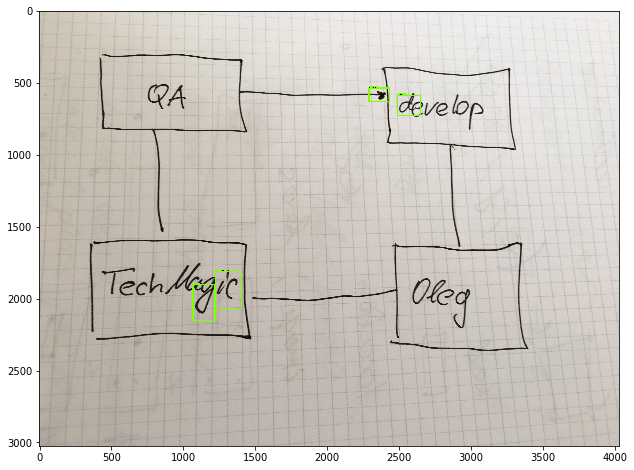

12:13:23


In [157]:
print(time.strftime('%X'))
pipeline_vision_final(img_to_test)
print(time.strftime('%X'))

In [158]:
print(time.strftime('%X'))
__lines = process_lines(img_to_test)
print(len(__lines))
print(time.strftime('%X'))

12:13:23
('process groups lines', 1712, 61)
61
12:13:50


In [159]:
print(time.strftime('%X'))
__g_rectangles, __g_lines = geometry(__lines, [], img_to_test)
print(len(__g_rectangles), len(__g_lines))
print(time.strftime('%X'))

12:13:50
('connections', 127)
('clear rectangles', 182, 4)
('available_lines', 45, 99)
('line parents', 8)
(4, 6)
12:13:56


In [160]:
print(time.strftime('%X'))
ocr_google_vision(img_to_test, __g_rectangles)
print(time.strftime('%X'))

12:13:56
[((110, 149), u'TechMagic')]
[((519, 207), u'A')]
[((108, 181), u'develo')]
[((306, 317), u'CC')]
12:14:09


In [168]:
ocr_google_vision_test(img_to_test)

[((771, 511), u'QA'), ((2502, 576), u'develop'), ((482, 1779), u'TechMegCH'), ((2608, 1872), u'Oleo')]
